# Laboratorio 4: Modelos CNN #
# Ejercicio 1 #
*Maria-Ignacia Constanza Rojas García*

1. Implementar e evaluar el desempeño de una red neuronal U-net en el problema de segmentación de esclerosis múltiple.

In [1]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

In [2]:
class MSDataset(Dataset):
    def __init__(self, base_dir):
        self.samples = []
        self.size = (192, 192)
        self.base_dir = base_dir
        self._load_data()

    def _load_data(self):
        patients = sorted([p for p in os.listdir(self.base_dir) if p.startswith("patient_")])
        print("Cargando pacientes:", patients)

        for p in patients:
            p_path = os.path.join(self.base_dir, p)
            flair = os.path.join(p_path, "FLAIR.nii.gz")
            t1 = os.path.join(p_path, "T1W.nii.gz")
            t1ce = os.path.join(p_path, "T1WKS.nii.gz")
            t2 = os.path.join(p_path, "T2W.nii.gz")
            mask = os.path.join(p_path, "consensus_gt.nii.gz")

            if not all(os.path.exists(f) for f in [flair, t1, t1ce, t2, mask]):
                continue

            # Cargar todas las modalidades
            flair_nii = nib.load(flair).get_fdata()
            t1_nii = nib.load(t1).get_fdata()
            t1ce_nii = nib.load(t1ce).get_fdata()
            t2_nii = nib.load(t2).get_fdata()
            mask_nii = nib.load(mask).get_fdata()

            # Reescalar todas al tamaño de FLAIR
            target_shape = flair_nii.shape
            def resize_volume(vol, target_shape):
                vol_t = torch.tensor(vol).unsqueeze(0).unsqueeze(0).float()
                resized = F.interpolate(vol_t, size=target_shape, mode='trilinear', align_corners=False)
                return resized[0,0].numpy()

            t1_nii   = resize_volume(t1_nii, target_shape)
            t1ce_nii = resize_volume(t1ce_nii, target_shape)
            t2_nii   = resize_volume(t2_nii, target_shape)
            mask_nii = resize_volume(mask_nii, target_shape)

            for i in range(target_shape[2]):
                img = np.stack([
                    flair_nii[:, :, i],
                    t1_nii[:, :, i],
                    t1ce_nii[:, :, i],
                    t2_nii[:, :, i]
                ], axis=0)

                msk = mask_nii[:, :, i]
                if msk.sum() == 0:
                    continue

                img = self.normalize(img)
                img, msk = self.resize_with_padding(img, msk)
                self.samples.append((img, msk))

        print(f"Dataset creado con {len(self.samples)} cortes útiles.")

    def normalize(self, img):
        img = (img - np.mean(img)) / (np.std(img) + 1e-8)
        return img

    def resize_with_padding(self, img, mask):
        target_h, target_w = self.size
        c, h, w = img.shape

        scale = min(target_h / h, target_w / w)
        new_h, new_w = int(h * scale), int(w * scale)

        img_resized = F.interpolate(
            torch.tensor(img).unsqueeze(0),
            size=(new_h, new_w),
            mode='bilinear',
            align_corners=False
        )[0].numpy()

        mask_resized = F.interpolate(
            torch.tensor(mask).unsqueeze(0).unsqueeze(0),
            size=(new_h, new_w),
            mode='nearest'
        )[0, 0].numpy()

        pad_h = (target_h - new_h) // 2
        pad_w = (target_w - new_w) // 2

        img_padded = np.pad(img_resized, ((0, 0), (pad_h, target_h - new_h - pad_h),
                                          (pad_w, target_w - new_w - pad_w)))
        mask_padded = np.pad(mask_resized, ((pad_h, target_h - new_h - pad_h),
                                            (pad_w, target_w - new_w - pad_w)))

        return img_padded, mask_padded

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(0)

In [3]:
base_dir = r"C:\Users\miroj\Downloads\data"
ds = MSDataset(base_dir)

x, y = ds[0]
print("Shape entrada:", x.shape)
print("Shape máscara:", y.shape)
print("Suma máscara:", y.sum())

Cargando pacientes: ['patient_01', 'patient_02', 'patient_03', 'patient_04', 'patient_05']
Dataset creado con 1122 cortes útiles.
Shape entrada: torch.Size([4, 192, 192])
Shape máscara: torch.Size([1, 192, 192])
Suma máscara: tensor(14.)


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet2D(nn.Module):
    def __init__(self, in_ch=4, out_ch=1):
        super().__init__()
        self.d1 = DoubleConv(in_ch, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)
        self.bottom = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.uconv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.uconv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.uconv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.uconv1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(F.max_pool2d(x1, 2))
        x3 = self.d3(F.max_pool2d(x2, 2))
        x4 = self.d4(F.max_pool2d(x3, 2))
        x5 = self.bottom(F.max_pool2d(x4, 2))

        x = self.up4(x5)
        x = self.uconv4(torch.cat([x, x4], dim=1))
        x = self.up3(x)
        x = self.uconv3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.uconv2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.uconv1(torch.cat([x, x1], dim=1))
        return torch.sigmoid(self.out_conv(x))

In [5]:
base_dir = r"C:\Users\miroj\Downloads\data"
ds = MSDataset(base_dir)
dl = DataLoader(ds, batch_size=2, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)
model = UNet2D().to(device)

criterion = lambda pred, target: 0.5 * F.binary_cross_entropy(pred, target) + \
                                 0.5 * (1 - (2 * (pred * target).sum() + 1e-8) /
                                        (pred.sum() + target.sum() + 1e-8))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Cargando pacientes: ['patient_01', 'patient_02', 'patient_03', 'patient_04', 'patient_05']
Dataset creado con 1122 cortes útiles.
Usando: cuda


In [6]:
from tqdm import tqdm

n_epochs = 10 

model.train()
for epoch in range(n_epochs):
    total_loss = 0
    pbar = tqdm(dl, desc=f"Época {epoch+1}/{n_epochs}", unit="batch")

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(dl)
    print(f"Época {epoch+1}/{n_epochs} - Pérdida promedio: {avg_loss:.4f}")

# Guardar modelo entrenado
torch.save(model.state_dict(), "unet_brain.pt")
print("Modelo guardado como unet_brain.pt")

Época 1/10: 100%|██████████| 561/561 [01:55<00:00,  4.87batch/s, loss=0.5569]


Época 1/10 - Pérdida promedio: 0.6029


Época 2/10: 100%|██████████| 561/561 [01:54<00:00,  4.91batch/s, loss=0.4491]


Época 2/10 - Pérdida promedio: 0.4992


Época 3/10: 100%|██████████| 561/561 [01:56<00:00,  4.80batch/s, loss=0.1640]


Época 3/10 - Pérdida promedio: 0.3911


Época 4/10: 100%|██████████| 561/561 [01:54<00:00,  4.91batch/s, loss=0.2163]


Época 4/10 - Pérdida promedio: 0.2540


Época 5/10: 100%|██████████| 561/561 [01:54<00:00,  4.90batch/s, loss=0.2834]


Época 5/10 - Pérdida promedio: 0.1796


Época 6/10: 100%|██████████| 561/561 [01:52<00:00,  4.98batch/s, loss=0.1581]


Época 6/10 - Pérdida promedio: 0.1537


Época 7/10: 100%|██████████| 561/561 [01:52<00:00,  4.98batch/s, loss=0.1340]


Época 7/10 - Pérdida promedio: 0.1457


Época 8/10: 100%|██████████| 561/561 [01:52<00:00,  4.97batch/s, loss=0.4118]


Época 8/10 - Pérdida promedio: 0.1296


Época 9/10: 100%|██████████| 561/561 [01:52<00:00,  4.98batch/s, loss=0.0266]


Época 9/10 - Pérdida promedio: 0.1329


Época 10/10: 100%|██████████| 561/561 [01:52<00:00,  4.97batch/s, loss=0.0902]


Época 10/10 - Pérdida promedio: 0.1203
Modelo guardado como unet_brain.pt


Generando gráfico para el índice: 25


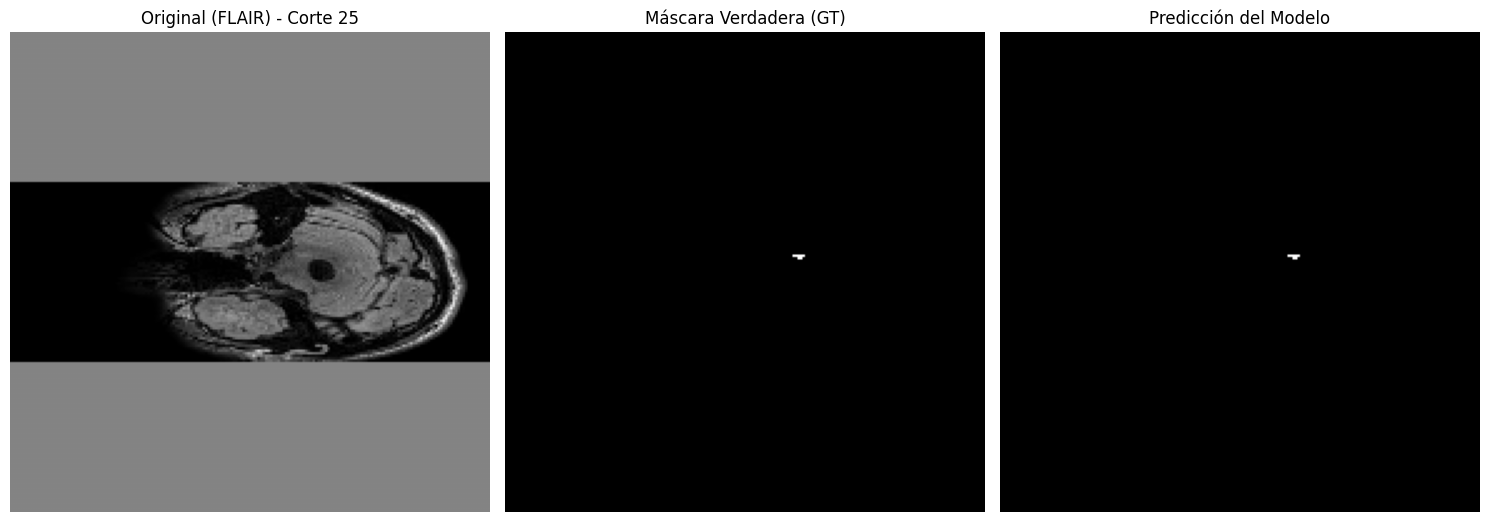

Generando gráfico para el índice: 120


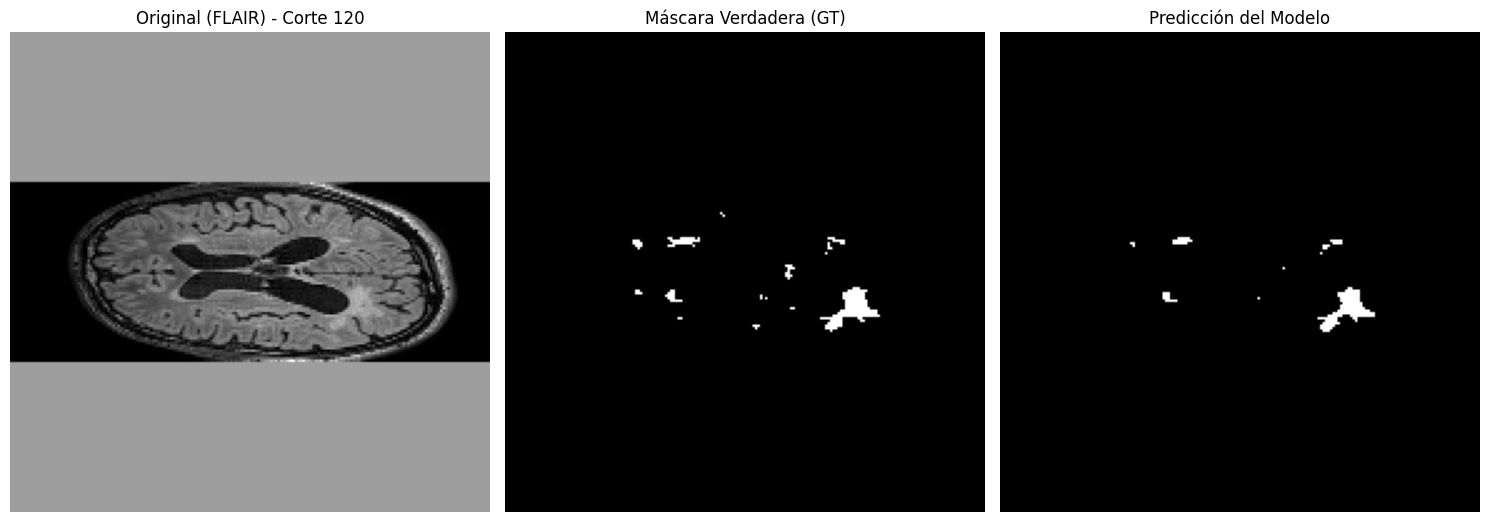

In [7]:
def visualizar_prediccion_simple(model, dataset, device, index):
    """
    Muestra 3 imágenes: Original (FLAIR), Máscara Verdadera (GT) y Predicción.
    """
    print(f"Generando gráfico para el índice: {index}")
    
    model.eval() 
    
    try:
        x, y = dataset[index]
    except IndexError:
        print(f"Error: El índice {index} está fuera de rango.")
        return

    x_tensor = x.unsqueeze(0).to(device)

    with torch.no_grad(): 
        pred_tensor = model(x_tensor)

    x_np = x.cpu().numpy()
    y_np = y.squeeze(0).cpu().numpy() 
    
    pred_np = (pred_tensor.squeeze(0).squeeze(0).cpu().numpy() > 0.5).astype(float)

    fig, axes = plt.subplots(1, 3, figsize=(15, 6)) 
    axes[0].imshow(x_np[0], cmap='gray')
    axes[0].set_title(f'Original (FLAIR) - Corte {index}')
    axes[0].axis('off')

    axes[1].imshow(y_np, cmap='gray')
    axes[1].set_title('Máscara Verdadera (GT)')
    axes[1].axis('off')

    axes[2].imshow(pred_np, cmap='gray') 
    axes[2].set_title('Predicción del Modelo')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show() 

visualizar_prediccion_simple(model, ds, device, index=25)

visualizar_prediccion_simple(model, ds, device, index=120)

In [ ]:
from torch.utils.data import DataLoader

model.eval() 

def calcular_metricas(pred_tensor, target_tensor, threshold=0.5, epsilon=1e-6):
    pred_bin = (pred_tensor > threshold).float()
    target_bin = (target_tensor == 1).float()
    
    # Calcular TP, FP, FN, TN
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    tn = ((1 - pred_bin) * (1 - target_bin)).sum()
    
    dice = (2 * tp) / (2 * tp + fp + fn + epsilon)
    iou = tp / (tp + fp + fn + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    specificity = tn / (tn + fp + epsilon)
    
    metrics = {
        "dice": dice.item(),
        "iou": iou.item(),
        "accuracy": accuracy.item(),
        "precision": precision.item(),
        "recall_sensitivity": recall.item(),
        "specificity": specificity.item()
    }
    return metrics

def evaluar_modelo(model, dataset, device, batch_size=8):

    dl_eval = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    model.eval() 
    
    all_metrics = {
        "dice": [], "iou": [], "accuracy": [],
        "precision": [], "recall_sensitivity": [], "specificity": []
    }
    
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dl_eval, desc="Calculando Métricas"):
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device) 
            
            pred_batch = model(x_batch)
            
            for i in range(pred_batch.shape[0]):
                pred_i = pred_batch[i] # Predicción para la imagen i
                y_i = y_batch[i]       # Máscara real para la imagen i
                
                metrics = calcular_metricas(pred_i, y_i)
                for key, value in metrics.items():
                    all_metrics[key].append(value)

    avg_metrics = {
        key: np.mean(values) for key, values in all_metrics.items()
    }
    
    return avg_metrics

print("Iniciando evaluación del modelo...")
metricas_promedio = evaluar_modelo(model, ds, device)

print("\nResultados de la Evaluación (Promedio)")
print(f"Coeficiente de Dice:    {metricas_promedio['dice']:.4f}")
print(f"IoU (Jaccard):          {metricas_promedio['iou']:.4f}")
print(f"Accuracy:               {metricas_promedio['accuracy']:.4f}")
print(f"Precision:              {metricas_promedio['precision']:.4f}")
print(f"Recall (Sensitivity):   {metricas_promedio['recall_sensitivity']:.4f}")
print(f"Specificity:            {metricas_promedio['specificity']:.4f}")

Iniciando evaluación del modelo...


Calculando Métricas: 100%|██████████| 141/141 [00:30<00:00,  4.67it/s]


Resultados de la Evaluación (Promedio)
Coeficiente de Dice:    0.6831
IoU (Jaccard):          0.5622
Accuracy:               0.9988
Precision:              0.7823
Recall (Sensitivity):   0.6214
Specificity:            0.9997


# Resultados de Evaluación del Modelo

## Métricas

### Coeficiente de Dice (Dice Score) → 0.6831
Mide la similitud entre la predicción del modelo y la verdad de terreno (ground truth).  
Va de 0 a 1, donde 1 significa perfecta coincidencia.  
0.68 indica que el modelo acierta bastante, pero todavía se puede mejorar (por ejemplo, haciendo más epochs).

### IoU o Jaccard → 0.5622
Intersection over Union (IoU) mide la intersección entre la predicción y la verdad de terreno dividida por su unión.  
También va de 0 a 1.  
0.5622 significa que alrededor del 56% de las predicciones coinciden con la región real.

### Accuracy → 0.9988
Proporción de predicciones correctas sobre todas las predicciones.  
Muy alta (99.88%), pero si el dataset está desbalanceado (muchos píxeles de fondo), este valor no es verdadero, el cual es el caso.

### Precision → 0.7823
Mide qué proporción de predicciones positivas son realmente positivas.  
0.78 significa que de todas las regiones que el modelo marcó como positivas, el 78% es correcto.

### Recall (Sensitivity) → 0.6214
Mide qué proporción de los positivos reales fueron detectados por el modelo.  
0.62 indica que el modelo no detecta todos los verdaderos positivos, es algo conservador.

### Specificity → 0.9997
Mide qué proporción de negativos reales fueron correctamente identificados.  
Muy alto (99.97%), lo que significa que casi nunca marca falso positivo.


## Resumen
El modelo es exitoso para no marcar falsos positivos (alta *specificity*) y tiene alta precisión.  
Sin embargo, el recall moderado indica que algunas regiones positivas se pierden.  
El Dice e IoU muestran un desempeño aceptable pero mejorable.